# State of the Art Comparison on MNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns 

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss

from macest.classification import models as clmod
from macest.classification import metrics as clmet
from macest.classification import plots as clplot
from macest.model_selection import KFoldConfidenceSplit

import dirichletcal.calib.tempscaling as temp
import dirichletcal.calib.fulldirichlet as dirich

In [3]:
sns.set_context("notebook")
sns.set_style('darkgrid')

In [4]:
# Uncomment this section if you have a `SSL: CERTIFICATE_VERIFY_FAILED` error
# See: https://github.com/scikit-learn/scikit-learn/issues/10201

# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
mnist = datasets.fetch_openml(name="mnist_784")
X = mnist.data.astype('float64')
y = mnist.target

In [6]:
X = X/256

In [7]:
enc = LabelEncoder()
y = enc.fit_transform(y)

### We do not want to work with the raw pixel values as features so we will take principal components

In [8]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.6, random_state=1)

pca = PCA(n_components=50)
pca.fit(X_pp_train)

X_pp_train = pca.transform(X_pp_train)
X_conf_train = pca.transform(X_conf_train)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.4, random_state=0)

In [9]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)

model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
print(model.score(X_pp_train, y_pp_train))
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))
print(model.score(X_test, y_test))

1.0
0.9476190476190476
0.9446428571428571
0.9504464285714286


In [11]:
print(X_pp_train.shape)
print(X_conf_train.shape)
print(X_cal.shape)
print(X_test.shape)

(28000, 50)
(25200, 50)
(10080, 50)
(6720, 50)


### Set the MACEst Parameters

In [12]:
param_bounds = clmod.SearchBounds(k_bounds = (5,50))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1000))
optimiser_args = dict(popsize = 25, disp = False)

In [13]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal,
               y_cal,
               param_range = param_bounds,
               optimiser_args= optimiser_args)

In [14]:
preds = model.predict(X_cal)
conf_preds = macest_model.predict_proba(X_cal)
rf_conf = model.predict_proba(X_cal)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_cal)

### We will also calibrate the predictions using some SOTA calibrators to compare with

In [15]:
isotonic = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method='isotonic')

isotonic.fit(X_conf_train, y_conf_train)
isot = isotonic.predict_proba(X_cal)
isot_point_prediction_conf = isot[np.arange(len(isot)), preds]

platt = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method= 'sigmoid')

platt.fit(X_conf_train, y_conf_train)
plat = platt.predict_proba(X_cal)
platt_point_prediction_conf = plat[np.arange(len(plat)), preds]

tcal = temp.TemperatureScaling()
tcal.fit(model.predict_proba(X_conf_train), y_conf_train)
tcal_conf = tcal.predict_proba(model.predict_proba(X_cal))
tcal_point_prediction_conf = tcal_conf[np.arange(len(tcal_conf)), preds]

ful_dir = dirich.FullDirichletCalibrator()
ful_dir.fit(model.predict_proba(X_conf_train), y_conf_train)
dir_conf = ful_dir.predict_proba(model.predict_proba(X_cal))
dir_point_prediction_conf = dir_conf[np.arange(len(tcal_conf)), preds]

## Unseen Data

### Plot the reliability diagrams as well as barplots comparing calibration and forecast metrics

In [16]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf = model.predict_proba(X_test)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test)

In [17]:
isot = isotonic.predict_proba(X_test)
isot_point_prediction_conf = isot[np.arange(len(isot)), preds]

plat = platt.predict_proba(X_test)
platt_point_prediction_conf = plat[np.arange(len(plat)), preds]

tcal_conf = tcal.predict_proba(model.predict_proba(X_test))
tcal_point_prediction_conf = tcal_conf[np.arange(len(tcal_conf)), preds]

dir_conf = ful_dir.predict_proba(model.predict_proba(X_test))
dir_point_prediction_conf = dir_conf[np.arange(len(dir_conf)), preds]

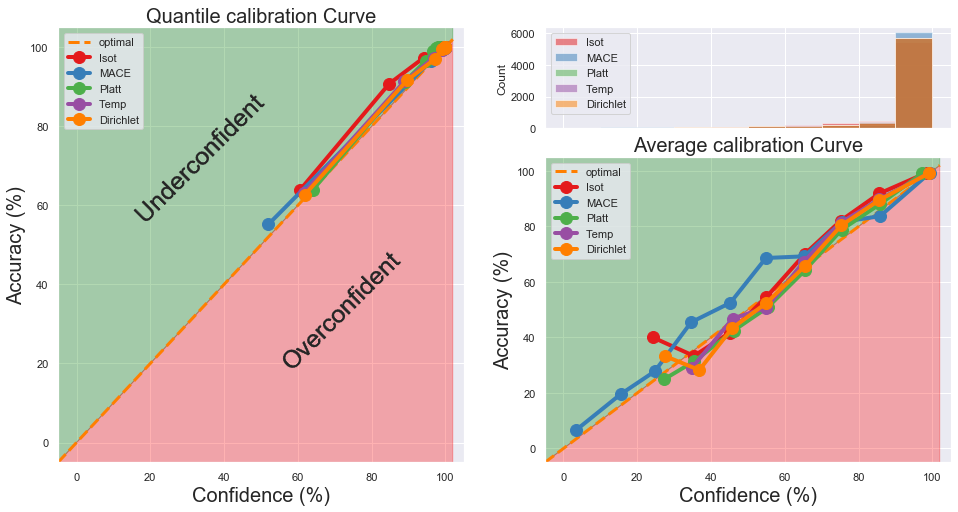

In [18]:
clplot.plot_calibration_curve([isot_point_prediction_conf,
                               macest_point_prediction_conf, 
                               platt_point_prediction_conf, 
                               tcal_point_prediction_conf, 
                               dir_point_prediction_conf], 
                               ['Isot', 'MACE', 'Platt', 'Temp', 'Dirichlet'],
                               preds, y_test)

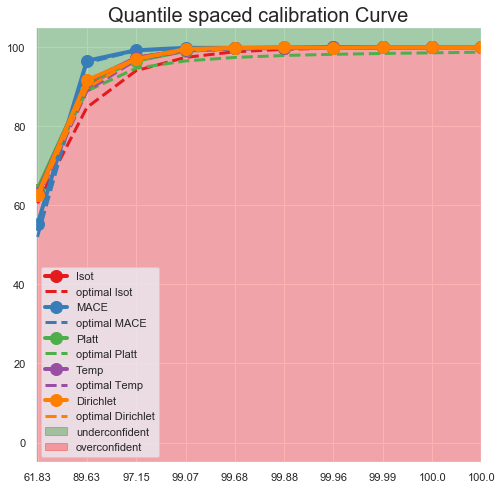

In [19]:
clplot.plot_quantile_spaced_calibration_curve([isot_point_prediction_conf,
                               macest_point_prediction_conf, 
                               platt_point_prediction_conf, 
                               tcal_point_prediction_conf, 
                               dir_point_prediction_conf], 
                               ['Isot', 'MACE', 'Platt', 'Temp', 'Dirichlet'],
                               preds, y_test)

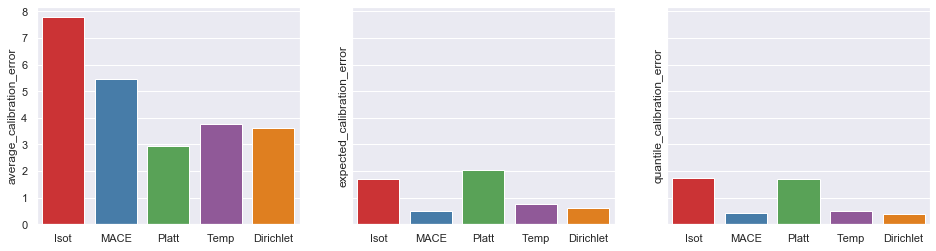

In [20]:
clplot.plot_calibration_metrics([isot_point_prediction_conf,
                               macest_point_prediction_conf, 
                               platt_point_prediction_conf, 
                               tcal_point_prediction_conf, 
                               dir_point_prediction_conf], 
                               ['Isot', 'MACE', 'Platt', 'Temp', 'Dirichlet'],
                               preds, y_test)

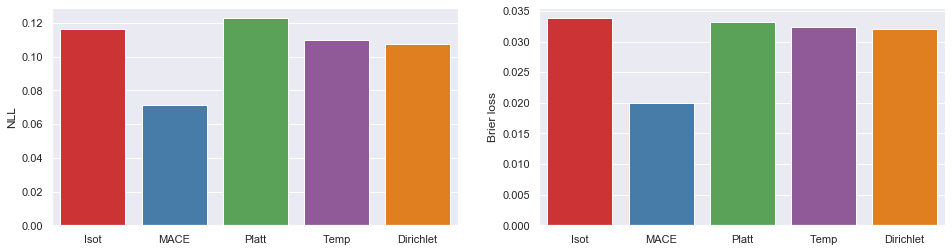

In [21]:
clplot.plot_forecast_metrics([isot_point_prediction_conf,
                               macest_point_prediction_conf, 
                               platt_point_prediction_conf, 
                               tcal_point_prediction_conf, 
                               dir_point_prediction_conf], 
                               ['Isot', 'MACE', 'Platt', 'Temp', 'Dirichlet'],
                               preds, y_test)

### Here we will highlight a key difference between MACE and other Calibrators by attempting to classify noise

In [22]:
np.random.seed(10)
fake_points = np.random.uniform(0,1,
                                size = (10**4, 784), 
                               )
test_point = fake_points[0].reshape(28,28)

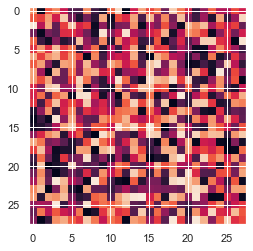

In [23]:
plt.imshow(test_point,
           interpolation='nearest')
plt.show()

In [24]:
fake_points = pca.transform(fake_points)

In [25]:
mace = macest_model.predict_confidence_of_point_prediction(fake_points[0:5])
iso = np.amax(isotonic.predict_proba(fake_points[0:5]), axis=1)

In [26]:
tmp =  np.amax(tcal.predict_proba(model.predict_proba(fake_points[0:5])), axis=1)
diric = np.amax(ful_dir.predict_proba(model.predict_proba(fake_points[0:5])), axis=1)

In [27]:
model.predict(fake_points)[0]

2

#### The point prediction Model says that this point is a 2, MACE reports a low confidence for this whereas each of the others are > 75% confident
#### This is because MACE is an independent estimate rather than trying to scale the model confidence

In [28]:
mace[0]

0.08357014631193067

In [29]:
tmp[0]

0.8499596539405173

In [30]:
iso[0]

0.8708164890988592

In [31]:
diric[0]

0.8702822924088637

### Let's generate a bunch of noise points and compare the predicted confidence distributions
### We see here that MACEst is able to detect out of sample predictions and report low confidence for these

In [32]:
fake_points = np.random.uniform(0,1, size = (10**3, 784))
fake_points = pca.transform(fake_points)

mace = macest_model.predict_confidence_of_point_prediction(fake_points)
iso = np.amax(isotonic.predict_proba(fake_points), axis=1)
plat = np.amax(platt.predict_proba(fake_points), axis=1)
temperature = np.amax(tcal.predict_proba(model.predict_proba(fake_points)), axis=1)
diri = np.amax(ful_dir.predict_proba(model.predict_proba(fake_points)), axis=1)


/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

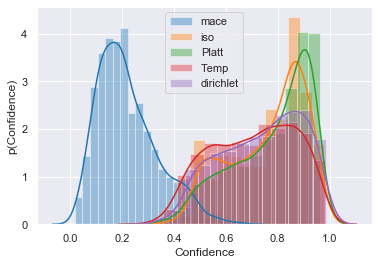

In [33]:
sns.distplot(mace, label = 'mace')
sns.distplot(iso, label = 'iso')
sns.distplot(plat, label = 'Platt')
sns.distplot(temperature, label = 'Temp')
sns.distplot(diri, label = 'dirichlet')
plt.ylabel('p(Confidence)')
plt.xlabel('Confidence')
plt.legend()

/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

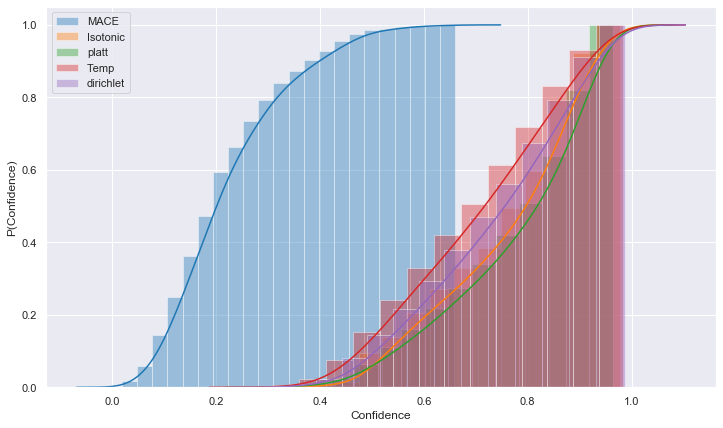

In [34]:
plt.figure(figsize = (12,7))

sns.distplot(mace,
             kde_kws = dict(cumulative=True),
             hist_kws = dict(cumulative=True),
             label = 'MACE')

sns.distplot(iso, 
             kde_kws = dict(cumulative=True),
             hist_kws = dict(cumulative=True),
             label = 'Isotonic')

sns.distplot(plat, 
             kde_kws = dict(cumulative=True),
             hist_kws = dict(cumulative=True),
             label = 'platt')

sns.distplot(temperature, 
             kde_kws = dict(cumulative=True),
             hist_kws = dict(cumulative=True),
             label = 'Temp')

sns.distplot(diri, 
             kde_kws = dict(cumulative=True),
             hist_kws = dict(cumulative=True),
             label = 'dirichlet')

plt.ylabel('P(Confidence)')
plt.xlabel('Confidence')
plt.legend()

### Let's compare MACEst with the other SOTA calibrators using k fold classification

In [35]:
X = mnist.data.astype('float64')
y = mnist.target

In [36]:
X = X/256

In [37]:
enc = LabelEncoder()
y = enc.fit_transform(y)

In [38]:
hsnw_params = clmod.HnswGraphArgs(init_args= dict(method = 'hnsw',
                                                  space = 'l2'))

optimiser_args = dict(popsize = 30, disp =False)

param_range = clmod.SearchBounds(k_bounds = (5,30))

In [39]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =200,
                               n_jobs =-1)
    
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
model.score(X_test, y_test)

0.9498511904761905

### Compute calibration errors for existing state of the art calibration methods

Prime error recording lists

In [41]:
accuracy = []

macest_ece, macest_pwece, macest_nll, macest_brier = [], [], [], []
macest_cal_ece, is_cal_ece, platt_cal_ece, temp_cal_ece, diri_cal_ece = [], [], [], [], []
is_ece, is_pwece, is_nll, is_brier = [], [], [], []
platt_ece, platt_pwece, platt_nll, platt_brier = [], [], [], []
temp_ece, temp_pwece, temp_nll, temp_brier = [], [], [], []

diri_ece, diri_pwece, diri_nll, diri_brier = [], [], [], []

kfold = KFoldConfidenceSplit(n_splits =5,
                             pp_train_graph_cal_split = (0.5, 0.15, 0.35))

optimiser_args = dict(popsize = 20, disp =False)

Compute calibration errors over the folds

In [42]:
i = 0

for train_idxs, conf_cal_idxs, conf_graph_idxs, test_idxs in kfold.split(X):
    print(" ")
    print(f'starting fold {i}' )
    
    X_pp_train = X[train_idxs]
    y_pp_train =  y[train_idxs]
    
    X_test = X[test_idxs]
    y_test = y[test_idxs]
    
    X_cal = X[conf_cal_idxs]
    y_cal = y[conf_cal_idxs]
    
    X_conf_train = X[conf_graph_idxs]
    y_conf_train = y[conf_graph_idxs]
    
    pca = PCA(n_components=50)
    pca.fit(X_pp_train)
    
    pca.fit(X_pp_train, y_pp_train)

    X_pp_train = pca.transform(X_pp_train)
    X_conf_train = pca.transform(X_conf_train)
    X_cal = pca.transform(X_cal)
    X_test = pca.transform(X_test)

    model = RandomForestClassifier(random_state =0,
                                   n_estimators =200,
                                   n_jobs =-1)
    
    model.fit(X_pp_train, y_pp_train)
    
    accuracy.append(model.score(X_test, y_test))

    mace = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args =hsnw_params)

    mace.fit(X_cal, y_cal, optimiser_args = optimiser_args)
    
    isotonic = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method='isotonic')
    isotonic.fit(X_conf_train, y_conf_train)
    
    platt = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method='sigmoid')
    
    platt.fit(X_conf_train, y_conf_train)
    
    tcal = temp.TemperatureScaling()
    tcal.fit(model.predict_proba(X_conf_train), y_conf_train)
    ful_dir = dirich.FullDirichletCalibrator()
    ful_dir.fit(model.predict_proba(X_conf_train), y_conf_train)

    preds = model.predict(X_test)
    correct = preds == y_test

    macest_conf_preds = mace.predict_confidence_of_point_prediction(X_test)
    is_conf_preds = np.amax(isotonic.predict_proba(X_test), axis=1)
    platt_conf_preds = np.amax(platt.predict_proba(X_test), axis=1)
    temp_conf_preds =  np.amax(tcal.predict_proba(model.predict_proba(X_test)), axis=1)
    diri_conf_preds = np.amax(ful_dir.predict_proba(model.predict_proba(X_test)), axis=1)
    
    macest_ece.append(clmet.expected_calibration_error(preds, y_test, macest_conf_preds))
    print(macest_ece[i])
    macest_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, macest_conf_preds))
    macest_nll.append(log_loss(correct, macest_conf_preds))
    macest_brier.append(brier_score_loss(correct, macest_conf_preds))
    
    macest_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(macest_conf_preds,
                                                       samples =10**3)))
    
    is_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(is_conf_preds,
                                                       samples =10**3)))
    
    platt_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(platt_conf_preds,
                                                       samples =10**3)))
    
    temp_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(temp_conf_preds,
                                                       samples =10**3)))
    
    diri_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(diri_conf_preds,
                                                     samples =10**3)))

    is_ece.append(clmet.expected_calibration_error(preds, y_test, is_conf_preds))
    is_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, is_conf_preds))
    is_nll.append(log_loss(correct, is_conf_preds))
    is_brier.append(brier_score_loss(correct, is_conf_preds))
    
    platt_ece.append(clmet.expected_calibration_error(preds, y_test, platt_conf_preds))
    platt_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, platt_conf_preds))
    platt_nll.append(log_loss(correct, platt_conf_preds))
    platt_brier.append(brier_score_loss(correct, platt_conf_preds))
    
    temp_ece.append(clmet.expected_calibration_error(preds, y_test, temp_conf_preds))
    temp_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, temp_conf_preds))
    temp_nll.append(log_loss(correct, temp_conf_preds))
    temp_brier.append(brier_score_loss(correct, temp_conf_preds))
    
    diri_ece.append(clmet.expected_calibration_error(preds, y_test, diri_conf_preds))
    diri_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, diri_conf_preds))
    diri_nll.append(log_loss(correct, diri_conf_preds))
    diri_brier.append(brier_score_loss(correct, diri_conf_preds))
    
    i +=1 

 
starting fold 0
0.49966141572224215
 
starting fold 1
0.49447242038115796
 
starting fold 2
0.7329824974341285
 
starting fold 3
0.596459695376894
 
starting fold 4
0.5101631455871911


### We now compare MACEst with the other classifiers on a variety of metrics

In [48]:
labels = ['MACEst', 'Isotonic', 'Platt', 'Temperature', 'Dirichlet']

Text(0, 0.5, 'ECE')

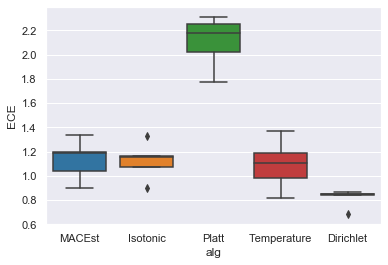

In [49]:
ece_df = pd.DataFrame([macest_pwece, is_pwece, platt_pwece, temp_pwece, diri_pwece], 
                      index=labels).unstack().reset_index()
ece_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=ece_df)
plt.ylabel('ECE')

Text(0, 0.5, 'CwECE')

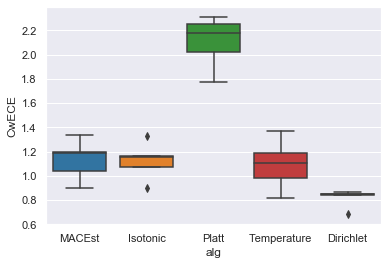

In [50]:
cwece_df = pd.DataFrame([macest_pwece, is_pwece, platt_pwece, temp_pwece, diri_pwece], 
                        index=labels).unstack().reset_index()
cwece_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=cwece_df)
plt.ylabel('CwECE')

Text(0, 0.5, 'NLL')

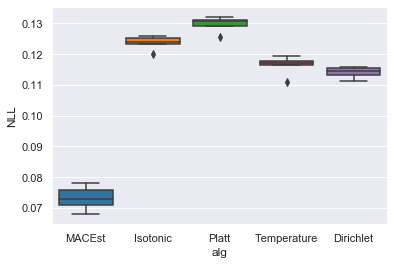

In [51]:
nll_df = pd.DataFrame([macest_nll, is_nll, platt_nll, temp_nll, diri_nll], 
                      index=labels).unstack().reset_index()
nll_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=nll_df)
plt.ylabel('NLL')

Text(0, 0.5, 'Brier')

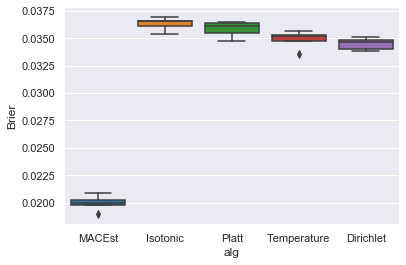

In [52]:
brier_df = pd.DataFrame([macest_brier, is_brier, platt_brier, temp_brier, diri_brier], 
                        index=labels).unstack().reset_index()
brier_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=brier_df)
plt.ylabel('Brier')